### **IDS 561 YouTube Trending Analytics**

In [1]:
# Accessing the file in drive by mounting Google drive in runtime's virtual machine

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install pyspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz  
!tar -xvf spark-3.0.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
# Install findspark and untar spark
!pip install pyspark
!pip install findspark

In [4]:
# Setting up the environment
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

In [5]:
# Create Spark session and sqlContext

import findspark
findspark.init()

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
spark = SparkSession.builder.master("local[*]").getOrCreate()
from pyspark.sql import SQLContext
from pyspark import SparkContext
sc =SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [6]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize,RegexpTokenizer
import re
import itertools 
from collections import Counter
from string import punctuation
from itertools import groupby
from operator import itemgetter

from textblob import TextBlob
nltk.download('punkt')

#Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
# Importing the dataset
USData = spark.read.csv('/content/drive/My Drive/USvideos.csv', inferSchema=True, header=True)
USData.show()

+-----------+-------------+--------------------+--------------------+-----------+--------------------+--------------------+-------+------+--------+-------------+--------------------+-----------------+----------------+----------------------+--------------------+
|   video_id|trending_date|               title|       channel_title|category_id|        publish_time|                tags|  views| likes|dislikes|comment_count|      thumbnail_link|comments_disabled|ratings_disabled|video_error_or_removed|         description|
+-----------+-------------+--------------------+--------------------+-----------+--------------------+--------------------+-------+------+--------+-------------+--------------------+-----------------+----------------+----------------------+--------------------+
|2kyS6SvSYSE|     17.14.11|WE WANT TO TALK A...|        CaseyNeistat|         22|2017-11-13T17:13:...|     SHANtell martin| 748374| 57527|    2966|        15954|https://i.ytimg.c...|            False|           Fal

In [81]:
# Extracting Description
USsenti = USData.select('video_id','description')
USsenti.show()

+-----------+--------------------+
|   video_id|         description|
+-----------+--------------------+
|2kyS6SvSYSE|SHANTELL'S CHANNE...|
|1ZAPwfrtAFY|One year after th...|
|5qpjK5DgCt4|WATCH MY PREVIOUS...|
|puqaWrEC7tY|Today we find out...|
|d380meD0W0M|I know it's been ...|
|gHZ1Qz0KiKM|Using the iPhone ...|
|39idVpFF7NQ|Embattled Alabama...|
|nc99ccSXST0|Ice Cream Pint Co...|
|jr9QtXwC9vc|Inspired by the i...|
|TUmyygCMMGA|For now, at least...|
|9wRQljFNDW8|New England Patri...|
|VifQlJit6A0|Shiva arrives jus...|
|5E4ZBSInqUU|WATCH SILENCE MUS...|
|GgVmn66oK_A|The world at larg...|
|TaTleo4cOs8|Today we go shopp...|
|kgaO45SyaO4|For more informat...|
|ZAQs-ctOqXQ|Pacific Rim was s...|
|YVfyYrEmzgM|Check out our Pat...|
|eNSN6qet1kE|aaaannnd now to f...|
|B5HORANmzHw|Thanks to 23AndMe...|
+-----------+--------------------+
only showing top 20 rows



In [10]:
# Removing None
USDesc = USsenti[USsenti['description']!="None"]
USDesc.show()

+-----------+--------------------+
|   video_id|         description|
+-----------+--------------------+
|2kyS6SvSYSE|SHANTELL'S CHANNE...|
|1ZAPwfrtAFY|One year after th...|
|5qpjK5DgCt4|WATCH MY PREVIOUS...|
|puqaWrEC7tY|Today we find out...|
|d380meD0W0M|I know it's been ...|
|gHZ1Qz0KiKM|Using the iPhone ...|
|39idVpFF7NQ|Embattled Alabama...|
|nc99ccSXST0|Ice Cream Pint Co...|
|jr9QtXwC9vc|Inspired by the i...|
|TUmyygCMMGA|For now, at least...|
|9wRQljFNDW8|New England Patri...|
|VifQlJit6A0|Shiva arrives jus...|
|5E4ZBSInqUU|WATCH SILENCE MUS...|
|GgVmn66oK_A|The world at larg...|
|TaTleo4cOs8|Today we go shopp...|
|kgaO45SyaO4|For more informat...|
|ZAQs-ctOqXQ|Pacific Rim was s...|
|YVfyYrEmzgM|Check out our Pat...|
|eNSN6qet1kE|aaaannnd now to f...|
|B5HORANmzHw|Thanks to 23AndMe...|
+-----------+--------------------+
only showing top 20 rows



In [11]:
USDescPandas = USDesc.toPandas()
USDescPandas.shape

(40390, 2)

In [12]:
# Calculating the Sentiment Polarity of Description

pol=[] # list which will contain the polarity of the comments
for i in USDescPandas.description.values:
    try:
        analysis =TextBlob(i)
        pol.append(analysis.sentiment.polarity)
        
    except:
        pol.append(0)

In [13]:
USDescPandas['pol']= pol

In [14]:
USDescPandas.head(10)

,video_id,description,pol
0,2kyS6SvSYSE,SHANTELL'S CHANNEL - https://www.youtube.com/s...,-0.166667
1,1ZAPwfrtAFY,"One year after the presidential election, John...",0.079167
2,5qpjK5DgCt4,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,0.145833
3,puqaWrEC7tY,Today we find out if Link is a Nickelback amat...,-0.017330
4,d380meD0W0M,I know it's been a while since we did this sho...,0.459091
5,gHZ1Qz0KiKM,Using the iPhone for the past two weeks -- her...,0.160156
6,39idVpFF7NQ,Embattled Alabama Senate candidate Roy Moore (...,0.275000
7,nc99ccSXST0,Ice Cream Pint Combination Lock - http://amzn....,-0.125000
8,jr9QtXwC9vc,"Inspired by the imagination of P.T. Barnum, Th...",0.363725
9,TUmyygCMMGA,"For now, at least, we have better things to wo...",0.071667


In [15]:
USDescPandas.pol.value_counts()

0.000000    4063
0.500000     944
0.250000     682
0.400000     517
0.136364     360
            ... 
0.284343       1
0.254545       1
0.235795       1
0.083442       1
0.100794       1
Name: pol, Length: 3707, dtype: int64

In [16]:
# Converting to the desired type
UsDataPn=USData.toPandas()
UsDataPn['views']=pd.to_numeric(UsDataPn['views'], errors='coerce')
UsDataPn['likes']=pd.to_numeric(UsDataPn['likes'], errors='coerce')
UsDataPn['dislikes']=pd.to_numeric(UsDataPn['dislikes'], errors='coerce')
UsDataPn['comment_count']=pd.to_numeric(UsDataPn['comment_count'], errors='coerce')
UsDataPn=UsDataPn.dropna()
UsDataPn['descPol']=USDescPandas['pol']
UsDataPn['ldr']=UsDataPn['likes']/UsDataPn['dislikes']
UsDataPn['liker']=UsDataPn['likes']/UsDataPn['views']
UsDataPn['commr']=UsDataPn['comment_count']/UsDataPn['views']
UsDataPn

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,descPol,ldr,liker,commr
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374.0,57527.0,2966.0,15954.0,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,-0.166667,19.395482,0.076869,0.021318
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"""last week tonight trump presidency""|""last wee...",2418783.0,97185.0,6146.0,12703.0,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",0.079167,15.812724,0.040179,0.005252
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"""racist superman""|""rudy""|""mancuso""|""king""|""bac...",3191434.0,146033.0,5339.0,8181.0,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,0.145833,27.352126,0.045758,0.002563
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"""rhett and link""|""gmm""|""good mythical morning""...",343168.0,10172.0,666.0,2146.0,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,-0.017330,15.273273,0.029641,0.006253
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"""ryan""|""higa""|""higatv""|""nigahiga""|""i dare you""...",2095731.0,132235.0,1989.0,17518.0,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,0.459091,66.483157,0.063097,0.008359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48131,1PhPYr_9zRY,18.14.06,BTS Plays With Puppies While Answering Fan Que...,BuzzFeed Celeb,22,2018-05-18T16:39:29.000Z,"""BuzzFeed""|""BuzzFeedVideo""|""Puppy Interview""|""...",8259128.0,645888.0,4052.0,62610.0,https://i.ytimg.com/vi/1PhPYr_9zRY/default.jpg,False,False,False,"BTS with the PPS, the puppies. These adorable ...",NaN,159.399803,0.078203,0.007581
48132,BZt0qjTWNhw,18.14.06,The Cat Who Caught the Laser,AaronsAnimals,15,2018-05-18T13:00:04.000Z,"""aarons animals""|""aarons""|""animals""|""cat""|""cat...",1685609.0,38160.0,1385.0,2657.0,https://i.ytimg.com/vi/BZt0qjTWNhw/default.jpg,False,False,False,The Cat Who Caught the Laser - Aaron's Animals,NaN,27.552347,0.022639,0.001576
48134,D6Oy4LfoqsU,18.14.06,I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...,Brad Mondo,24,2018-05-18T17:34:22.000Z,"""I gave safiya nygaard a perfect hair makeover...",1066451.0,48068.0,1032.0,3992.0,https://i.ytimg.com/vi/D6Oy4LfoqsU/default.jpg,False,False,False,I had so much fun transforming Safiyas hair in...,NaN,46.577519,0.045073,0.003743
48135,oV0zkMe1K8s,18.14.06,How Black Panther Should Have Ended,How It Should Have Ended,1,2018-05-17T17:00:04.000Z,"""Black Panther""|""HISHE""|""Marvel""|""Infinity War...",5660813.0,192957.0,2846.0,13088.0,https://i.ytimg.com/vi/oV0zkMe1K8s/default.jpg,False,False,False,How Black Panther Should Have EndedWatch More ...,NaN,67.799368,0.034086,0.002312


In [17]:
from scipy import stats

In [18]:
desccor=UsDataPn.dropna()

In [19]:
stats.spearmanr(desccor['liker'],desccor['descPol'])

SpearmanrResult(correlation=-0.0008704863585135293, pvalue=0.8738922733255614)

In [20]:
stats.spearmanr(desccor['commr'],desccor['descPol'])

SpearmanrResult(correlation=0.003029164790847611, pvalue=0.5807352027366774)

In [21]:
stats.spearmanr(desccor['ldr'],desccor['descPol'])

SpearmanrResult(correlation=-0.0026241959428206047, pvalue=0.6323139990288499)

In [22]:
stats.spearmanr(desccor['views'],desccor['descPol'])

SpearmanrResult(correlation=0.0034972106582940856, pvalue=0.5237009091763586)


**Maybe compare with title, tags and desc for video to be trending**

In [23]:
# Analysis on Tags
USTags = USData.select('video_id','tags')
USTags.show()

+-----------+--------------------+
|   video_id|                tags|
+-----------+--------------------+
|2kyS6SvSYSE|     SHANtell martin|
|1ZAPwfrtAFY|"last week tonigh...|
|5qpjK5DgCt4|"racist superman"...|
|puqaWrEC7tY|"rhett and link"|...|
|d380meD0W0M|"ryan"|"higa"|"hi...|
|gHZ1Qz0KiKM|"ijustine"|"week ...|
|39idVpFF7NQ|"SNL"|"Saturday N...|
|nc99ccSXST0|"5 Ice Cream Gadg...|
|jr9QtXwC9vc|"Trailer"|"Hugh J...|
|TUmyygCMMGA|"vox.com"|"vox"|"...|
|9wRQljFNDW8|"NFL"|"Football"|...|
|VifQlJit6A0|"The Walking Dead...|
|5E4ZBSInqUU|"marshmello"|"blo...|
|GgVmn66oK_A|"nowthis"|"nowthi...|
|TaTleo4cOs8|"shopping for new...|
|kgaO45SyaO4|"Robots"|"Boston ...|
|ZAQs-ctOqXQ|"pacific rim"|"pa...|
|YVfyYrEmzgM|"TED"|"TED-Ed"|"T...|
|eNSN6qet1kE|"ultralight"|"air...|
|B5HORANmzHw|"SciShow"|"scienc...|
+-----------+--------------------+
only showing top 20 rows



In [24]:
# Filtering tags
USTags = USTags[USTags['tags']!="None"]
USTags.show()

+-----------+--------------------+
|   video_id|                tags|
+-----------+--------------------+
|2kyS6SvSYSE|     SHANtell martin|
|1ZAPwfrtAFY|"last week tonigh...|
|5qpjK5DgCt4|"racist superman"...|
|puqaWrEC7tY|"rhett and link"|...|
|d380meD0W0M|"ryan"|"higa"|"hi...|
|gHZ1Qz0KiKM|"ijustine"|"week ...|
|39idVpFF7NQ|"SNL"|"Saturday N...|
|nc99ccSXST0|"5 Ice Cream Gadg...|
|jr9QtXwC9vc|"Trailer"|"Hugh J...|
|TUmyygCMMGA|"vox.com"|"vox"|"...|
|9wRQljFNDW8|"NFL"|"Football"|...|
|VifQlJit6A0|"The Walking Dead...|
|5E4ZBSInqUU|"marshmello"|"blo...|
|GgVmn66oK_A|"nowthis"|"nowthi...|
|TaTleo4cOs8|"shopping for new...|
|kgaO45SyaO4|"Robots"|"Boston ...|
|ZAQs-ctOqXQ|"pacific rim"|"pa...|
|YVfyYrEmzgM|"TED"|"TED-Ed"|"T...|
|eNSN6qet1kE|"ultralight"|"air...|
|B5HORANmzHw|"SciShow"|"scienc...|
+-----------+--------------------+
only showing top 20 rows



In [25]:
USTagsPandas = USTags.toPandas()
USTagsPandas.shape

(41116, 2)

In [26]:
# Calculating the Sentiment Polarity of Tags

polTags=[] # list which will contain the polarity of the tags
for i in USTagsPandas.tags.values:
    try:
        analysis =TextBlob(i)
        polTags.append(analysis.sentiment.polarity)
        
    except:
        polTags.append(0)

In [27]:
USTagsPandas['pol']= polTags

In [28]:
USTagsPandas.head(10)

,video_id,tags,pol
0,2kyS6SvSYSE,SHANtell martin,0.000000
1,1ZAPwfrtAFY,"""last week tonight trump presidency""|""last wee...",0.000000
2,5qpjK5DgCt4,"""racist superman""|""rudy""|""mancuso""|""king""|""bac...",0.111111
3,puqaWrEC7tY,"""rhett and link""|""gmm""|""good mythical morning""...",0.266667
4,d380meD0W0M,"""ryan""|""higa""|""higatv""|""nigahiga""|""i dare you""...",-0.350000
5,gHZ1Qz0KiKM,"""ijustine""|""week with iPhone X""|""iphone x""|""ap...",0.000000
6,39idVpFF7NQ,"""SNL""|""Saturday Night Live""|""SNL Season 43""|""E...",0.112238
7,nc99ccSXST0,"""5 Ice Cream Gadgets""|""Ice Cream""|""Cream Sandw...",0.000000
8,jr9QtXwC9vc,"""Trailer""|""Hugh Jackman""|""Michelle Williams""|""...",0.416000
9,TUmyygCMMGA,"""vox.com""|""vox""|""explain""|""shift change""|""futu...",0.000000


In [29]:
UsDataPn['tagPol']=USTagsPandas['pol']
UsDataPn['tagPol']

0        0.000000
1        0.000000
2        0.111111
3        0.266667
4       -0.350000
           ...   
48131         NaN
48132         NaN
48134         NaN
48135         NaN
48136         NaN
Name: tagPol, Length: 40379, dtype: float64

In [30]:
UsDataPn.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,descPol,ldr,liker,commr,tagPol
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374.0,57527.0,2966.0,15954.0,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,-0.166667,19.395482,0.076869,0.021318,0.000000
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"""last week tonight trump presidency""|""last wee...",2418783.0,97185.0,6146.0,12703.0,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",0.079167,15.812724,0.040179,0.005252,0.000000
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"""racist superman""|""rudy""|""mancuso""|""king""|""bac...",3191434.0,146033.0,5339.0,8181.0,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,0.145833,27.352126,0.045758,0.002563,0.111111
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"""rhett and link""|""gmm""|""good mythical morning""...",343168.0,10172.0,666.0,2146.0,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,-0.017330,15.273273,0.029641,0.006253,0.266667
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"""ryan""|""higa""|""higatv""|""nigahiga""|""i dare you""...",2095731.0,132235.0,1989.0,17518.0,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,0.459091,66.483157,0.063097,0.008359,-0.350000


In [31]:
tagcor=UsDataPn.dropna()

In [32]:
# Finding correlation with Tags

stats.spearmanr(tagcor['views'],tagcor['tagPol'])

SpearmanrResult(correlation=-0.010095920450278404, pvalue=0.06564448273235063)

In [33]:
stats.spearmanr(tagcor['ldr'],tagcor['tagPol'])

SpearmanrResult(correlation=-0.006165721342466628, pvalue=0.2609234218399504)

In [34]:
stats.spearmanr(tagcor['commr'],tagcor['tagPol'])

SpearmanrResult(correlation=0.005666754394232338, pvalue=0.30149541746548064)

In [35]:
stats.spearmanr(tagcor['liker'],tagcor['tagPol'])

SpearmanrResult(correlation=-0.00013236970008234606, pvalue=0.9807448728944386)

In [36]:
# Sentiment analysis on Title
USTitle = USData.select('video_id','title')
USTitle.show()


+-----------+--------------------+
|   video_id|               title|
+-----------+--------------------+
|2kyS6SvSYSE|WE WANT TO TALK A...|
|1ZAPwfrtAFY|The Trump Preside...|
|5qpjK5DgCt4|Racist Superman |...|
|puqaWrEC7tY|Nickelback Lyrics...|
|d380meD0W0M|I Dare You: GOING...|
|gHZ1Qz0KiKM|2 Weeks with iPho...|
|39idVpFF7NQ|Roy Moore & Jeff ...|
|nc99ccSXST0|5 Ice Cream Gadge...|
|jr9QtXwC9vc|The Greatest Show...|
|TUmyygCMMGA|Why the rise of t...|
|9wRQljFNDW8|Dion Lewis' 103-Y...|
|VifQlJit6A0|(SPOILERS) 'Shiva...|
|5E4ZBSInqUU|Marshmello - Bloc...|
|GgVmn66oK_A|Which Countries A...|
|TaTleo4cOs8|SHOPPING FOR NEW ...|
|kgaO45SyaO4|    The New SpotMini|
|ZAQs-ctOqXQ|One Change That W...|
|YVfyYrEmzgM|How does your bod...|
|eNSN6qet1kE|HomeMade Electric...|
|B5HORANmzHw|Founding An Inbre...|
+-----------+--------------------+
only showing top 20 rows



In [37]:
# Filtering tags
USTitle = USTitle[USTitle['title']!="None"]
USTitle.show()

+-----------+--------------------+
|   video_id|               title|
+-----------+--------------------+
|2kyS6SvSYSE|WE WANT TO TALK A...|
|1ZAPwfrtAFY|The Trump Preside...|
|5qpjK5DgCt4|Racist Superman |...|
|puqaWrEC7tY|Nickelback Lyrics...|
|d380meD0W0M|I Dare You: GOING...|
|gHZ1Qz0KiKM|2 Weeks with iPho...|
|39idVpFF7NQ|Roy Moore & Jeff ...|
|nc99ccSXST0|5 Ice Cream Gadge...|
|jr9QtXwC9vc|The Greatest Show...|
|TUmyygCMMGA|Why the rise of t...|
|9wRQljFNDW8|Dion Lewis' 103-Y...|
|VifQlJit6A0|(SPOILERS) 'Shiva...|
|5E4ZBSInqUU|Marshmello - Bloc...|
|GgVmn66oK_A|Which Countries A...|
|TaTleo4cOs8|SHOPPING FOR NEW ...|
|kgaO45SyaO4|    The New SpotMini|
|ZAQs-ctOqXQ|One Change That W...|
|YVfyYrEmzgM|How does your bod...|
|eNSN6qet1kE|HomeMade Electric...|
|B5HORANmzHw|Founding An Inbre...|
+-----------+--------------------+
only showing top 20 rows



In [38]:
USTitlePandas = USTitle.toPandas()
USTitlePandas.shape

(42235, 2)

In [39]:
# Calculating the Sentiment Polarity of Title

polTitle=[] # list which will contain the polarity of the comments
for i in USTitlePandas.title.values:
    try:
        analysis =TextBlob(i)
        polTitle.append(analysis.sentiment.polarity)
        
    except:
        polTitle.append(0)

In [40]:
USTitlePandas['pol']= polTitle

In [41]:
USTitlePandas.head()

,video_id,title,pol
0,2kyS6SvSYSE,WE WANT TO TALK ABOUT OUR MARRIAGE,0.00
1,1ZAPwfrtAFY,The Trump Presidency: Last Week Tonight with J...,0.00
2,5qpjK5DgCt4,"Racist Superman | Rudy Mancuso, King Bach & Le...",0.00
3,puqaWrEC7tY,Nickelback Lyrics: Real or Fake?,-0.75
4,d380meD0W0M,I Dare You: GOING BALD!?,0.00


In [42]:
# USTitlePandas, USTagsPandas, USDescPandas

In [43]:
# Adding title Polarity values

UsDataPn['titlePol']=USTitlePandas['pol']
titlecorr=UsDataPn.dropna()

In [44]:
stats.spearmanr(titlecorr['views'],titlecorr['titlePol'])

SpearmanrResult(correlation=0.007287177221959225, pvalue=0.1839489187794785)

In [45]:
stats.spearmanr(titlecorr['ldr'],titlecorr['titlePol'])

SpearmanrResult(correlation=0.007180668279672705, pvalue=0.19044173522127825)

In [46]:
stats.spearmanr(titlecorr['commr'],titlecorr['titlePol'])

SpearmanrResult(correlation=-0.004906115738030544, pvalue=0.3710324428805767)

In [47]:
stats.spearmanr(titlecorr['liker'],titlecorr['titlePol'])

SpearmanrResult(correlation=-0.0006184827539708999, pvalue=0.910214146972165)

In [48]:
# Analyis on UK Data

# Importing the UK dataset
UKData = spark.read.csv('/content/drive/My Drive/GBvideos.csv', inferSchema=True, header=True)
UKData.show()

+-----------+-------------+--------------------+--------------------+-----------+--------------------+--------------------+--------+-------+--------+-------------+--------------------+-----------------+----------------+----------------------+--------------------+
|   video_id|trending_date|               title|       channel_title|category_id|        publish_time|                tags|   views|  likes|dislikes|comment_count|      thumbnail_link|comments_disabled|ratings_disabled|video_error_or_removed|         description|
+-----------+-------------+--------------------+--------------------+-----------+--------------------+--------------------+--------+-------+--------+-------------+--------------------+-----------------+----------------+----------------------+--------------------+
|Jw1Y-zhQURU|     17.14.11|John Lewis Christ...|          John Lewis|         26|2017-11-10T07:38:...|"christmas"|"john...| 7224515|  55681|   10247|         9479|https://i.ytimg.c...|            False|      

In [49]:
UKsenti = UKData.select('video_id','description')
UKsenti.show()
UKDesc = UKsenti[UKsenti['description']!="None"]
UKDesc.show()

+-----------+--------------------+
|   video_id|         description|
+-----------+--------------------+
|Jw1Y-zhQURU|Click here to con...|
|3s1rvMFUweQ|Musical guest Tay...|
|n1WpP7iowLc|Eminem's new trac...|
|PUTEiSjKwJU|Salford drew 4-4 ...|
|rHwDegptbI4|Dashcam captures ...|
|AumaWl0TNBo|► HOW MY RELATION...|
|2Vv-BfVoq4g|🎧: https://ad.gt...|
|-N5eucPMTTc|CHRISTMAS HAS GON...|
|LMCuKltaY3M|“Golden Slumbers”...|
|9t9u_yPEidY|Jennifer Lopez ft...|
|ONQ-fAp5X64|➢ Join my FREE 7 ...|
|Dlwf5u2BLAg|More from Inside ...|
|NVCqz2BDfcQ|Gucci Mane - Curv...|
|MyEqfBkzESU|-\n\n\nWebsite - ...|
|b4vTZx_AtHk|Today I show you ...|
|BsfhHKx6ajA|Trust us, there's...|
|DIU3xPdhCBI|You have to watch...|
|pz95u3UVpaM|Havana – Spotify ...|
|jp9hK-jY6yY|You know that fee...|
|gEHCXl4J9Qo|This intimate fan...|
+-----------+--------------------+
only showing top 20 rows

+-----------+--------------------+
|   video_id|         description|
+-----------+--------------------+
|Jw1Y-zhQURU|Click here to con

In [50]:
UKDescPandas = UKDesc.toPandas()
UKDescPandas.shape


(38338, 2)

In [51]:
# Calculating the Sentiment Polarity of Description

pol=[] # list which will contain the polarity of the description
for i in UKDescPandas.description.values:
    try:
        analysis =TextBlob(i)
        pol.append(analysis.sentiment.polarity)
        
    except:
        pol.append(0)

In [52]:
UKDescPandas['pol']= pol
UKDescPandas.head(10)

,video_id,description,pol
0,Jw1Y-zhQURU,Click here to continue the story and make your...,0.263889
1,3s1rvMFUweQ,Musical guest Taylor Swift performs …Ready for...,0.250000
2,n1WpP7iowLc,Eminem's new track Walk on Water ft. Beyoncé i...,0.507273
3,PUTEiSjKwJU,Salford drew 4-4 against the Class of 92 and F...,0.136364
4,rHwDegptbI4,Dashcam captures truck's near miss with child ...,0.100000
5,AumaWl0TNBo,► HOW MY RELATIONSHIP STARTED!\n► PB Merch • h...,0.000000
6,2Vv-BfVoq4g,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...,0.200000
7,-N5eucPMTTc,CHRISTMAS HAS GONE TO MY HEAD\nPrevious Vlog: ...,-0.037500
8,LMCuKltaY3M,"“Golden Slumbers”, originally by The Beatles, ...",0.351894
9,9t9u_yPEidY,"Jennifer Lopez ft. Wisin - Amor, Amor, Amor (O...",0.200000


In [53]:
# Converting to the desired type

UKDataPn = UKData.toPandas()
UKDataPn['views'] = pd.to_numeric(UKDataPn['views'], errors='coerce')
UKDataPn['likes'] = pd.to_numeric(UKDataPn['likes'], errors='coerce')
UKDataPn['dislikes'] = pd.to_numeric(UKDataPn['dislikes'], errors='coerce')
UKDataPn['comment_count'] = pd.to_numeric(UKDataPn['comment_count'], errors='coerce')
UKDataPn = UKDataPn.dropna()
UKDataPn['descPol'] = UKDescPandas['pol']
UKDataPn['ldr'] = UKDataPn['likes']/UKDataPn['dislikes']
UKDataPn['liker'] = UKDataPn['likes']/UKDataPn['views']
UKDataPn['commr']= UKDataPn['comment_count']/UKDataPn['views']
UKDataPn

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,descPol,ldr,liker,commr
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10T07:38:29.000Z,"""christmas""|""john lewis christmas""|""john lewis...",7224515.0,55681.0,10247.0,9479.0,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,0.263889,5.433883,0.007707,0.001312
1,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,24,2017-11-12T06:24:44.000Z,"""SNL""|""Saturday Night Live""|""SNL Season 43""|""E...",1053632.0,25561.0,2294.0,2757.0,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...,0.250000,11.142546,0.024260,0.002617
2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"""Eminem""|""Walk""|""On""|""Water""|""Aftermath/Shady/...",17158579.0,787420.0,43420.0,125882.0,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,0.507273,18.134961,0.045891,0.007336
3,PUTEiSjKwJU,17.14.11,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,17,2017-11-13T02:30:38.000Z,"""Salford City FC""|""Salford City""|""Salford""|""Cl...",27833.0,193.0,12.0,37.0,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,False,False,False,Salford drew 4-4 against the Class of 92 and F...,0.136364,16.083333,0.006934,0.001329
4,rHwDegptbI4,17.14.11,Dashcam captures truck's near miss with child ...,Cute Girl Videos,25,2017-11-13T01:45:13.000Z,[none],9815.0,30.0,2.0,30.0,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,False,False,False,Dashcam captures truck's near miss with child ...,0.100000,15.000000,0.003057,0.003057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43290,l884wKofd54,18.14.06,Enrique Iglesias - MOVE TO MIAMI (Official Vid...,EnriqueIglesiasVEVO,10,2018-05-09T07:00:01.000Z,"""Enrique Iglesias feat. Pitbull""|""MOVE TO MIAM...",25066952.0,268088.0,12783.0,9933.0,https://i.ytimg.com/vi/l884wKofd54/default.jpg,False,False,False,NEW SONG - MOVE TO MIAMI feat. Pitbull (Click ...,NaN,20.972229,0.010695,0.000396
43291,IP8k2xkhOdI,18.14.06,Jacob Sartorius - Up With It (Official Music V...,Jacob Sartorius,10,2018-05-11T17:09:16.000Z,"""jacob sartorius""|""jacob""|""up with it""|""jacob ...",1492219.0,61998.0,13781.0,24330.0,https://i.ytimg.com/vi/IP8k2xkhOdI/default.jpg,False,False,False,THE OFFICIAL UP WITH IT MUSIC VIDEO!Get my new...,NaN,4.498803,0.041548,0.016305
43292,Il-an3K9pjg,18.14.06,Anne-Marie - 2002 [Official Video],Anne-Marie,10,2018-05-08T11:05:08.000Z,"""anne""|""marie""|""anne-marie""|""2002""|""two thousa...",29641412.0,394830.0,8892.0,19988.0,https://i.ytimg.com/vi/Il-an3K9pjg/default.jpg,False,False,False,Get 2002 by Anne-Marie HERE ▶ http://ad.gt/200...,NaN,44.402834,0.013320,0.000674
43293,-DRsfNObKIQ,18.14.06,Eleni Foureira - Fuego - Cyprus - LIVE - First...,Eurovision Song Contest,24,2018-05-08T20:32:32.000Z,"""Eurovision Song Contest""|""2018""|""Lisbon""|""Cyp...",14317515.0,151870.0,45875.0,26766.0,https://i.ytimg.com/vi/-DRsfNObKIQ/default.jpg,False,False,False,Eleni Foureira represented Cyprus at the first...,NaN,3.310518,0.010607,0.001869


In [54]:
desccorUK = UKDataPn.dropna()

In [55]:
stats.spearmanr(desccorUK['liker'],desccorUK['descPol'])

SpearmanrResult(correlation=-0.008641855027108116, pvalue=0.11396336631267523)

In [56]:
stats.spearmanr(desccorUK['commr'],desccorUK['descPol'])

SpearmanrResult(correlation=-0.007659128999934374, pvalue=0.16125082070398217)

In [57]:
stats.spearmanr(desccorUK['ldr'],desccorUK['descPol'])

SpearmanrResult(correlation=-0.004445933393558229, pvalue=0.41612270095312165)

In [58]:
stats.spearmanr(desccorUK['views'],desccorUK['descPol'])

SpearmanrResult(correlation=0.004905275454399186, pvalue=0.3696220835157922)

In [59]:
# Analysis on Tags of UK
UKTags = UKData.select('video_id','tags')
UKTags.show()

+-----------+--------------------+
|   video_id|                tags|
+-----------+--------------------+
|Jw1Y-zhQURU|"christmas"|"john...|
|3s1rvMFUweQ|"SNL"|"Saturday N...|
|n1WpP7iowLc|"Eminem"|"Walk"|"...|
|PUTEiSjKwJU|"Salford City FC"...|
|rHwDegptbI4|              [none]|
|AumaWl0TNBo|"pointlessblog"|"...|
|2Vv-BfVoq4g|"edsheeran"|"ed s...|
|-N5eucPMTTc|"zoe sugg"|"zoell...|
|LMCuKltaY3M|"Elbow"|"Golden"|...|
|9t9u_yPEidY|"Jennifer Lopez f...|
|ONQ-fAp5X64|"nile wilson"|"ni...|
|Dlwf5u2BLAg|"reporter"|"robbe...|
|NVCqz2BDfcQ|"Gucci Mane"|"The...|
|MyEqfBkzESU|"Extreme Tan"|"Ta...|
|b4vTZx_AtHk|"how to dry a shi...|
|BsfhHKx6ajA|"rhett and link"|...|
|DIU3xPdhCBI|"bbc"|"music"|"bb...|
|pz95u3UVpaM|"camila cabello"|...|
|jp9hK-jY6yY|"iisuperwomanii"|...|
|gEHCXl4J9Qo|"American Broadca...|
+-----------+--------------------+
only showing top 20 rows



In [60]:
# Filtering tags
UKTags = UKTags[UKTags['tags']!="None"]
UKTags.show()

+-----------+--------------------+
|   video_id|                tags|
+-----------+--------------------+
|Jw1Y-zhQURU|"christmas"|"john...|
|3s1rvMFUweQ|"SNL"|"Saturday N...|
|n1WpP7iowLc|"Eminem"|"Walk"|"...|
|PUTEiSjKwJU|"Salford City FC"...|
|rHwDegptbI4|              [none]|
|AumaWl0TNBo|"pointlessblog"|"...|
|2Vv-BfVoq4g|"edsheeran"|"ed s...|
|-N5eucPMTTc|"zoe sugg"|"zoell...|
|LMCuKltaY3M|"Elbow"|"Golden"|...|
|9t9u_yPEidY|"Jennifer Lopez f...|
|ONQ-fAp5X64|"nile wilson"|"ni...|
|Dlwf5u2BLAg|"reporter"|"robbe...|
|NVCqz2BDfcQ|"Gucci Mane"|"The...|
|MyEqfBkzESU|"Extreme Tan"|"Ta...|
|b4vTZx_AtHk|"how to dry a shi...|
|BsfhHKx6ajA|"rhett and link"|...|
|DIU3xPdhCBI|"bbc"|"music"|"bb...|
|pz95u3UVpaM|"camila cabello"|...|
|jp9hK-jY6yY|"iisuperwomanii"|...|
|gEHCXl4J9Qo|"American Broadca...|
+-----------+--------------------+
only showing top 20 rows



In [61]:
UKTagsPandas = UKTags.toPandas()
UKTagsPandas.shape

(39053, 2)

In [62]:
# Calculating the Sentiment Polarity of UK Tags

polTags=[] # list which will contain the polarity of the tags
for i in UKTagsPandas.tags.values:
    try:
        analysis =TextBlob(i)
        polTags.append(analysis.sentiment.polarity)
        
    except:
        polTags.append(0)

In [63]:
UKTagsPandas['pol']= polTags

In [64]:
UKTagsPandas.head(10)

,video_id,tags,pol
0,Jw1Y-zhQURU,"""christmas""|""john lewis christmas""|""john lewis...",0.000000
1,3s1rvMFUweQ,"""SNL""|""Saturday Night Live""|""SNL Season 43""|""E...",0.188258
2,n1WpP7iowLc,"""Eminem""|""Walk""|""On""|""Water""|""Aftermath/Shady/...",0.000000
3,PUTEiSjKwJU,"""Salford City FC""|""Salford City""|""Salford""|""Cl...",0.000000
4,rHwDegptbI4,[none],0.000000
5,AumaWl0TNBo,"""pointlessblog""|""pointlessblogtv""|""pointlessbl...",0.168831
6,2Vv-BfVoq4g,"""edsheeran""|""ed sheeran""|""acoustic""|""live""|""co...",0.136364
7,-N5eucPMTTc,"""zoe sugg""|""zoella""|""zoe""|""vlog""|""vlogging""|""v...",0.000000
8,LMCuKltaY3M,"""Elbow""|""Golden""|""Slumbers""|""Polydor""|""Alterna...",0.300000
9,9t9u_yPEidY,"""Jennifer Lopez ft. Wisin""|""Jennifer Lopez ft....",-0.002165


In [65]:
UKDataPn['tagpol']=UKTagsPandas['pol']

In [66]:
tagcorUK=UKDataPn.dropna()

In [67]:
stats.spearmanr(tagcorUK['views'],tagcorUK['tagpol'])

SpearmanrResult(correlation=0.0012332540609657065, pvalue=0.8215416655382645)

In [68]:
stats.spearmanr(tagcorUK['ldr'],tagcorUK['tagpol'])

SpearmanrResult(correlation=0.0007769682177099969, pvalue=0.8869949364726988)

In [69]:
stats.spearmanr(tagcorUK['liker'],tagcorUK['tagpol'])

SpearmanrResult(correlation=0.005178592555334629, pvalue=0.3435510373514441)

In [70]:
stats.spearmanr(tagcorUK['commr'],tagcorUK['tagpol'])

SpearmanrResult(correlation=5.300778712696728e-05, pvalue=0.9922645208055461)

In [71]:
UKtitle = UKData.select('video_id','title')
UKtitle.show()

+-----------+--------------------+
|   video_id|               title|
+-----------+--------------------+
|Jw1Y-zhQURU|John Lewis Christ...|
|3s1rvMFUweQ|Taylor Swift: …Re...|
|n1WpP7iowLc|Eminem - Walk On ...|
|PUTEiSjKwJU|Goals from Salfor...|
|rHwDegptbI4|Dashcam captures ...|
|AumaWl0TNBo|How My Relationsh...|
|2Vv-BfVoq4g|Ed Sheeran - Perf...|
|-N5eucPMTTc|CHRISTMAS HAS GON...|
|LMCuKltaY3M|Elbow - Golden Sl...|
|9t9u_yPEidY|Jennifer Lopez - ...|
|ONQ-fAp5X64|CAN BABIES DO GYM...|
|Dlwf5u2BLAg|TV Reporter Inter...|
|NVCqz2BDfcQ|Gucci Mane  - Cur...|
|MyEqfBkzESU|EXTREME GOLDEN TA...|
|b4vTZx_AtHk|How To Dry a Shir...|
|BsfhHKx6ajA|Attracting An Alp...|
|DIU3xPdhCBI|Sam Smith surpris...|
|pz95u3UVpaM|Camila Cabello - ...|
|jp9hK-jY6yY|When Someone Has ...|
|gEHCXl4J9Qo|Taylor Swift - “N...|
+-----------+--------------------+
only showing top 20 rows



In [72]:
UKtitle = UKtitle[UKtitle['title']!="None"]
UKtitlePandas = UKtitle.toPandas()

In [73]:
polTitle=[] # list which will contain the polarity of the titles
for i in UKtitlePandas.title.values:
    try:
        analysis =TextBlob(i)
        polTitle.append(analysis.sentiment.polarity)
        
    except:
        polTitle.append(0)

In [74]:
UKtitlePandas['pol']= polTitle

In [75]:
UKDataPn['titlepol']=UKtitlePandas['pol']

In [76]:
titlecorUK=UKDataPn.dropna()

In [77]:
stats.spearmanr(titlecorUK['views'],titlecorUK['titlepol'])

SpearmanrResult(correlation=-0.004922439078149072, pvalue=0.3679495697386783)

In [78]:
stats.spearmanr(titlecorUK['ldr'],titlecorUK['titlepol'])

SpearmanrResult(correlation=-0.0005566860215831477, pvalue=0.9189011235165868)

In [79]:
stats.spearmanr(titlecorUK['liker'],titlecorUK['titlepol'])

SpearmanrResult(correlation=-0.0034525417461065606, pvalue=0.5277315484359706)

In [80]:
stats.spearmanr(titlecorUK['commr'],titlecorUK['titlepol'])

SpearmanrResult(correlation=0.005073298727722843, pvalue=0.3534524118026323)

In [91]:
UsDataPn.head(10)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,descPol,ldr,liker,commr,tagPol,titlePol
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374.0,57527.0,2966.0,15954.0,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,-1.0,19.395482,0.076869,0.021318,0.000000,0.0000
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"""last week tonight trump presidency""|""last wee...",2418783.0,97185.0,6146.0,12703.0,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",1.0,15.812724,0.040179,0.005252,0.000000,0.0000
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"""racist superman""|""rudy""|""mancuso""|""king""|""bac...",3191434.0,146033.0,5339.0,8181.0,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,1.0,27.352126,0.045758,0.002563,0.111111,0.0000
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"""rhett and link""|""gmm""|""good mythical morning""...",343168.0,10172.0,666.0,2146.0,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,-1.0,15.273273,0.029641,0.006253,0.266667,-0.7500
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"""ryan""|""higa""|""higatv""|""nigahiga""|""i dare you""...",2095731.0,132235.0,1989.0,17518.0,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,1.0,66.483157,0.063097,0.008359,-0.350000,0.0000
5,gHZ1Qz0KiKM,17.14.11,2 Weeks with iPhone X,iJustine,28,2017-11-13T19:07:23.000Z,"""ijustine""|""week with iPhone X""|""iphone x""|""ap...",119180.0,9763.0,511.0,1434.0,https://i.ytimg.com/vi/gHZ1Qz0KiKM/default.jpg,False,False,False,Using the iPhone for the past two weeks -- her...,1.0,19.105675,0.081918,0.012032,0.000000,0.0000
6,39idVpFF7NQ,17.14.11,Roy Moore & Jeff Sessions Cold Open - SNL,Saturday Night Live,24,2017-11-12T05:37:17.000Z,"""SNL""|""Saturday Night Live""|""SNL Season 43""|""E...",2103417.0,15993.0,2445.0,1970.0,https://i.ytimg.com/vi/39idVpFF7NQ/default.jpg,False,False,False,Embattled Alabama Senate candidate Roy Moore (...,1.0,6.541104,0.007603,0.000937,0.112238,-0.3000
7,nc99ccSXST0,17.14.11,5 Ice Cream Gadgets put to the Test,CrazyRussianHacker,28,2017-11-12T21:50:37.000Z,"""5 Ice Cream Gadgets""|""Ice Cream""|""Cream Sandw...",817732.0,23663.0,778.0,3432.0,https://i.ytimg.com/vi/nc99ccSXST0/default.jpg,False,False,False,Ice Cream Pint Combination Lock - http://amzn....,-1.0,30.415167,0.028937,0.004197,0.000000,0.0000
8,jr9QtXwC9vc,17.14.11,The Greatest Showman | Official Trailer 2 [HD]...,20th Century Fox,1,2017-11-13T14:00:23.000Z,"""Trailer""|""Hugh Jackman""|""Michelle Williams""|""...",826059.0,3543.0,119.0,340.0,https://i.ytimg.com/vi/jr9QtXwC9vc/default.jpg,False,False,False,"Inspired by the imagination of P.T. Barnum, Th...",1.0,29.773109,0.004289,0.000412,0.416000,0.5000
9,TUmyygCMMGA,17.14.11,Why the rise of the robots won’t mean the end ...,Vox,25,2017-11-13T13:45:16.000Z,"""vox.com""|""vox""|""explain""|""shift change""|""futu...",256426.0,12654.0,1363.0,2368.0,https://i.ytimg.com/vi/TUmyygCMMGA/default.jpg,False,False,False,"For now, at least, we have better things to wo...",1.0,9.283933,0.049348,0.009235,0.000000,-0.3125


### **Generating Histograms**

In [ ]:
#Converting the polarity values from continuous to categorical for US

UsDataPnCat = UsDataPn

UsDataPnCat['descPol'][UsDataPnCat.descPol==0]= 0
UsDataPnCat['descPol'][UsDataPnCat.descPol > 0]= 1
UsDataPnCat['descPol'][UsDataPnCat.descPol < 0]= -1

UsDataPnCat['tagPol'][UsDataPnCat.tagPol==0]= 0
UsDataPnCat['tagPol'][UsDataPnCat.tagPol > 0]= 1
UsDataPnCat['tagPol'][UsDataPnCat.tagPol < 0]= -1

UsDataPnCat['titlePol'][UsDataPnCat.titlePol==0]= 0
UsDataPnCat['titlePol'][UsDataPnCat.titlePol > 0]= 1
UsDataPnCat['titlePol'][UsDataPnCat.titlePol < 0]= -1

In [93]:
UsDataPnCat.head(10)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,descPol,ldr,liker,commr,tagPol,titlePol
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374.0,57527.0,2966.0,15954.0,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,-1.0,19.395482,0.076869,0.021318,0.0,0.0
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"""last week tonight trump presidency""|""last wee...",2418783.0,97185.0,6146.0,12703.0,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",1.0,15.812724,0.040179,0.005252,0.0,0.0
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"""racist superman""|""rudy""|""mancuso""|""king""|""bac...",3191434.0,146033.0,5339.0,8181.0,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,1.0,27.352126,0.045758,0.002563,1.0,0.0
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"""rhett and link""|""gmm""|""good mythical morning""...",343168.0,10172.0,666.0,2146.0,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,-1.0,15.273273,0.029641,0.006253,1.0,-1.0
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"""ryan""|""higa""|""higatv""|""nigahiga""|""i dare you""...",2095731.0,132235.0,1989.0,17518.0,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,1.0,66.483157,0.063097,0.008359,-1.0,0.0
5,gHZ1Qz0KiKM,17.14.11,2 Weeks with iPhone X,iJustine,28,2017-11-13T19:07:23.000Z,"""ijustine""|""week with iPhone X""|""iphone x""|""ap...",119180.0,9763.0,511.0,1434.0,https://i.ytimg.com/vi/gHZ1Qz0KiKM/default.jpg,False,False,False,Using the iPhone for the past two weeks -- her...,1.0,19.105675,0.081918,0.012032,0.0,0.0
6,39idVpFF7NQ,17.14.11,Roy Moore & Jeff Sessions Cold Open - SNL,Saturday Night Live,24,2017-11-12T05:37:17.000Z,"""SNL""|""Saturday Night Live""|""SNL Season 43""|""E...",2103417.0,15993.0,2445.0,1970.0,https://i.ytimg.com/vi/39idVpFF7NQ/default.jpg,False,False,False,Embattled Alabama Senate candidate Roy Moore (...,1.0,6.541104,0.007603,0.000937,1.0,-1.0
7,nc99ccSXST0,17.14.11,5 Ice Cream Gadgets put to the Test,CrazyRussianHacker,28,2017-11-12T21:50:37.000Z,"""5 Ice Cream Gadgets""|""Ice Cream""|""Cream Sandw...",817732.0,23663.0,778.0,3432.0,https://i.ytimg.com/vi/nc99ccSXST0/default.jpg,False,False,False,Ice Cream Pint Combination Lock - http://amzn....,-1.0,30.415167,0.028937,0.004197,0.0,0.0
8,jr9QtXwC9vc,17.14.11,The Greatest Showman | Official Trailer 2 [HD]...,20th Century Fox,1,2017-11-13T14:00:23.000Z,"""Trailer""|""Hugh Jackman""|""Michelle Williams""|""...",826059.0,3543.0,119.0,340.0,https://i.ytimg.com/vi/jr9QtXwC9vc/default.jpg,False,False,False,"Inspired by the imagination of P.T. Barnum, Th...",1.0,29.773109,0.004289,0.000412,1.0,1.0
9,TUmyygCMMGA,17.14.11,Why the rise of the robots won’t mean the end ...,Vox,25,2017-11-13T13:45:16.000Z,"""vox.com""|""vox""|""explain""|""shift change""|""futu...",256426.0,12654.0,1363.0,2368.0,https://i.ytimg.com/vi/TUmyygCMMGA/default.jpg,False,False,False,"For now, at least, we have better things to wo...",1.0,9.283933,0.049348,0.009235,0.0,-1.0


 1.0    26802
 0.0     3367
-1.0     3248
Name: descPol, dtype: int64

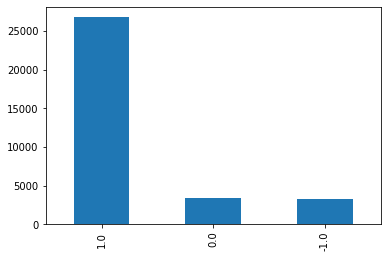

In [88]:
# Histogram of Description sentiments

UsDataPnCat.descPol.value_counts().plot.bar()
UsDataPnCat.descPol.value_counts()

 1.0    17095
 0.0    10397
-1.0     6530
Name: tagPol, dtype: int64

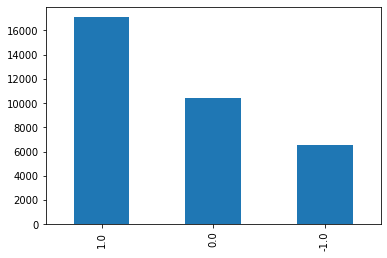

In [94]:
# Histogram of Tag sentiments

UsDataPnCat.tagPol.value_counts().plot.bar()
UsDataPnCat.tagPol.value_counts()

 0.0    20466
 1.0     9677
-1.0     4862
Name: titlePol, dtype: int64

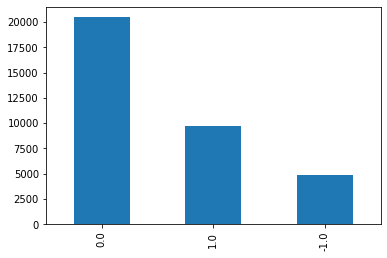

In [96]:
# Histogram of Title sentiments

UsDataPnCat.titlePol.value_counts().plot.bar()
UsDataPnCat.titlePol.value_counts()

In [98]:
UKDataPn.head(4)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,descPol,ldr,liker,commr,tagpol,titlepol
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10T07:38:29.000Z,"""christmas""|""john lewis christmas""|""john lewis...",7224515.0,55681.0,10247.0,9479.0,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,1.0,5.433883,0.007707,0.001312,0.000000,0.000000
1,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,24,2017-11-12T06:24:44.000Z,"""SNL""|""Saturday Night Live""|""SNL Season 43""|""E...",1053632.0,25561.0,2294.0,2757.0,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...,1.0,11.142546,0.024260,0.002617,0.188258,0.136364
2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"""Eminem""|""Walk""|""On""|""Water""|""Aftermath/Shady/...",17158579.0,787420.0,43420.0,125882.0,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,1.0,18.134961,0.045891,0.007336,0.000000,0.000000
3,PUTEiSjKwJU,17.14.11,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,17,2017-11-13T02:30:38.000Z,"""Salford City FC""|""Salford City""|""Salford""|""Cl...",27833.0,193.0,12.0,37.0,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,False,False,False,Salford drew 4-4 against the Class of 92 and F...,1.0,16.083333,0.006934,0.001329,0.000000,0.000000


In [ ]:
#Converting the polarity values from continuous to categorical for UK

UKDataPnCat = UKDataPn

UKDataPnCat['descPol'][UKDataPnCat.descPol==0]= 0
UKDataPnCat['descPol'][UKDataPnCat.descPol > 0]= 1
UKDataPnCat['descPol'][UKDataPnCat.descPol < 0]= -1

UKDataPnCat['tagpol'][UKDataPnCat.tagpol==0]= 0
UKDataPnCat['tagpol'][UKDataPnCat.tagpol > 0]= 1
UKDataPnCat['tagpol'][UKDataPnCat.tagpol < 0]= -1

UKDataPnCat['titlepol'][UKDataPnCat.titlepol==0]= 0
UKDataPnCat['titlepol'][UKDataPnCat.titlepol > 0]= 1
UKDataPnCat['titlepol'][UKDataPnCat.titlepol < 0]= -1

 1.0    24328
 0.0     5514
-1.0     3843
Name: descPol, dtype: int64

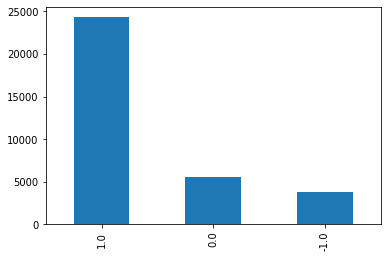

In [100]:
# Histogram of Description sentiments of UK

UKDataPnCat.descPol.value_counts().plot.bar()
UKDataPnCat.descPol.value_counts()

 1.0    15440
 0.0    12382
-1.0     6536
Name: tagpol, dtype: int64

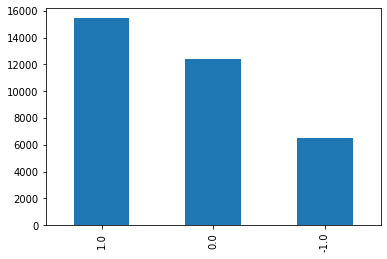

In [101]:
# Histogram of Tag sentiments of UK

UKDataPnCat.tagpol.value_counts().plot.bar()
UKDataPnCat.tagpol.value_counts()

 0.0    22082
 1.0     8325
-1.0     4406
Name: titlepol, dtype: int64

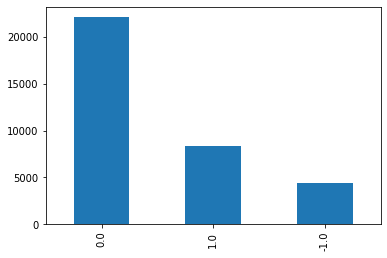

In [102]:
# Histogram of Title sentiments for UK

UKDataPnCat.titlepol.value_counts().plot.bar()
UKDataPnCat.titlepol.value_counts()